In [208]:
import os

%matplotlib inline
import matplotlib as mpl    
import matplotlib.pyplot as plt    
import matplotlib.gridspec
mpl.rcParams['figure.figsize'] = (14.0, 7.0)

import numpy as np
    
import grizli

In [209]:
# Fetch sample data
os.chdir('/tmp/')
os.system('wget http://www.stsci.edu/~brammer/grism/grizli_demo_data.tar.gz')
os.system('tar xzvf grizli_demo_data.tar.gz')

0

### Initialize the GrismFLT object
The `GrismFLT` object takes as input grism FLT files and optionally direct image FLT files or reference images and segmentation maps.  For this example, provide just a pair of grism (G141) and direct (F140W) FLT files (taken from a visit on the UDF field from 3D-HST).  

Note that the two FITS files provided here have been astrometrically aligned and background subtracted externally to `grizli` in its current implementation.  These are clearly critical and non-trivial steps of the data preparation process and this functionality will be incorporated into the full `grizli` release shortly.  

In [210]:
flt = grizli.model.GrismFLT(flt_file='ibhj34h8q_flt.fits', direct_image='ibhj34h6q_flt.fits', 
                            refimage=None, segimage=None, verbose=True, pad=0)

ibhj34h8q_flt.fits / Blot reference image: None


### Catalog / segmentation image
Make a catalog/segmentation image from the direct FLT and make a full grism model for the first four grism orders for those detected objects.  Uses `photutils` to generate the segmentation image/catalog.

In [211]:
flt.photutils_detection(detect_thresh=2, grow_seg=5, gauss_fwhm=2., 
                        compute_beams=['A','B','C','D'], 
                        verbose=False, save_detection=False, wcs=None)

Number of objects in `photutils` catalog: 210


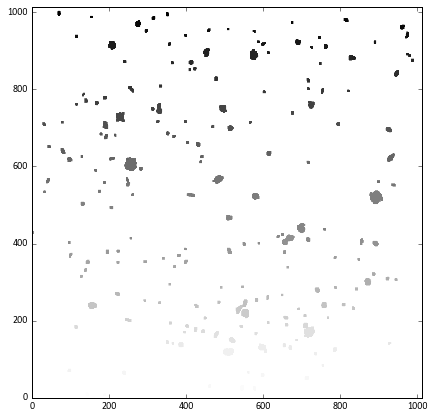

In [212]:
print 'Number of objects in `photutils` catalog: %d' %(len(flt.catalog))
plt.imshow(flt.seg, cmap='gray_r', origin='lower')

In [213]:
# Find the object near (x,y) = (712, 52) 
dr = np.sqrt((flt.catalog['xcentroid']-712)**2+(flt.catalog['ycentroid']-52)**2)
ix = np.argmin(dr)
id = flt.catalog['id'][ix]
x0 = flt.catalog['xcentroid'][ix]+1
y0 = flt.catalog['ycentroid'][ix]+1
print 'id=%d, (x,y)=(%.1f, %.1f)' %(id, x0, y0)

id=7, (x,y)=(713.0, 52.2)


### Basic trace parameters
Get basic trace parameters, `conf` is a grizli.grism.aXeConf object, here for G141 & F140W.

`dx` is simply the x pixel offset from the center of the direct image.  Here it is integers, but it can be anything.


In [214]:
# x pixels from the center of the direct image
dx = np.arange(220)
# ytrace and wavelength at x=dx
dy, lam = flt.conf.get_beam_trace(x=x0, y=y0, dx=dx, beam='A')
# it's fast
%timeit dy, lam = flt.conf.get_beam_trace(x=x0, y=y0, dx=dx, beam='A')

1000 loops, best of 3: 519 µs per loop


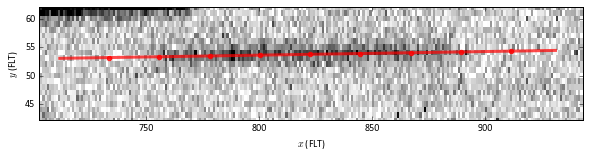

In [215]:
### Make a figure showing the trace in the FLT frame
fig = plt.figure(figsize=[8,2])

ax = fig.add_subplot(111)
ax.imshow(flt.im_data['SCI'], cmap='gray_r', vmin=-0.05, vmax=0.2, 
          interpolation='Nearest', aspect='auto')
ax.set_xlim(x0-10, x0+230); ax.set_ylim(y0-10, y0+10)

# plot the trace
ax.plot(x0+dx-1, y0+dy-1, color='red', linewidth=3, alpha=0.7)
## 0.1 micron tick marks along the trace as in the next figure
xint = np.interp(np.arange(1,1.81,0.1), lam/1.e4, dx)
yint = np.interp(np.arange(1,1.81,0.1), lam/1.e4, dy)
ax.scatter(x0+xint-1, y0+yint-1, marker='o', color='red', alpha=0.8)
ax.set_xlabel(r'$x$ (FLT)'); ax.set_ylabel(r'$y$ (FLT)')

fig.tight_layout(pad=0.1)
fig.savefig('grizli_demo_0.pdf')

### Creating model spectra for contamination and fitting
Above we created a full spectral model of the grism image based on the detected objects delineated in the segmentation map.  While the model creation was hidden inside the `photutils_detection` function, it's really the fundamental kernel that allows the user to generate model grism spectra based on the morphology in the direct image.  Below we show the full model as computed previously and also demonstrate the technique for computing a single spectral model, which is placed directly into the FLT frame.

Note that by default the model generation kernel arbitrarily *assumes flat source spectra in units of* $f_\lambda$, with a normalization given by the total flux density in the direct image integrated within the segmentation region.  

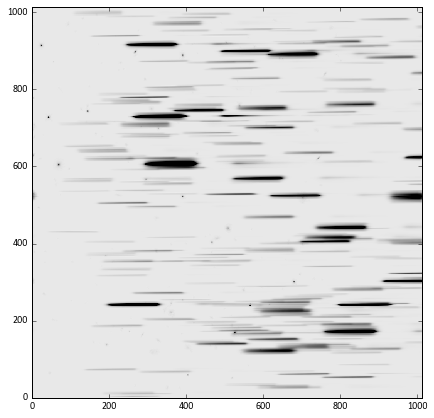

In [216]:
# Full model
plt.imshow(flt.model, interpolation='Nearest', vmin=-0.02, vmax=0.2, 
           cmap='gray_r', origin='lower')

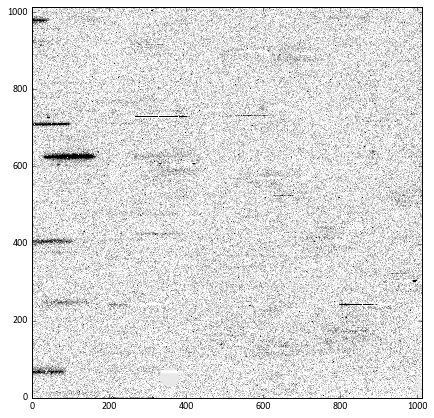

In [217]:
# residual
plt.imshow(flt.im_data['SCI'] - flt.model, interpolation='Nearest', vmin=-0.02, vmax=0.2, 
           cmap='gray_r', origin='lower')

# Note, some spectra on the left side of the image aren't modeled because they fall off of 
# the direct image.  This can be accounted for when using reference mosaics that cover areas 
# larger than the FLT frames themselves.

# Also, this is just a crude model with simple (wrong) assumptions about the object spectra!

### `GrismFLT.compute_model`
This is the workhorse function that disperses a spectrum based on the 2D morphology and flux normalization defined in the direct image.  Briefly, it uses the low-level `grism.aXeConf.get_beam_trace` function to compute the wavelengths and $y$ pixel offsets of the spectral trace as a function of $x$ distance from a pixel in the direct image.  The trace configuration defines how a given direct image pixel is dispersed by the grism (i.e., which wavelength maps to which pixel in the grism image).  `compute_model` simply computes this "pixel spectrum" mapping once for the central pixel within the object segment and then loops through all of the pixels in the segment scaling the dispersed pixel spectrum by the pixel values in the direct image and incrementing the array indices appropriately.  As this operation can be formulated simply as a list of array indices, the image lookup can be extremely fast utilizing C-based index manipulation (and it's probably not even as fast as it could be).

Again, with the default values `xspec=None`, `yspec=None`, the function assumes a flat spectrum in units of $f_\lambda$ flux density.

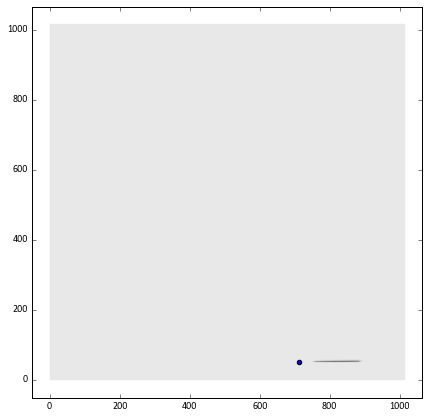

In [218]:
# Compute the model spectrum in the FLT frame for the single object.
# remove it from the overall master model (`flt.model`), as it will 
# include the spectrum of the object itself

# Note, need to `reshape` at the end because by default it spits out a flattened array 
# suitable for fast array indexing
model_id = flt.compute_model(id=id, x=x0, y=y0, sh=[80,80], in_place=False, 
                             xspec=None, yspec=None).reshape(flt.sh_pad)

# Show it
plt.imshow(model_id, interpolation='Nearest', vmin=-0.02, vmax=0.2, 
           cmap='gray_r', origin='lower')
plt.scatter(x0, y0, marker='o') # location in direct image

### Working with single objects
Now do some operations with the spectrum of a single object, selected as shown above.  Below the `BeamCutout` class duplicates some of the functionality of the `GrismFLT` class.  Note that the cutout is exactly that, i.e., slices of the various science and error arrays, direct images, segmentation images, etc.


In [219]:
# Spectrum cutout
beam = grizli.model.BeamCutout(id=id, x=x0, y=y0, cutout_dimensions=[18,18], 
                               conf=flt.conf, GrismFLT=flt)

# quick fix for masking any bad pixels in the direct FLT cutout
beam.cutout_seg[(beam.thumb/beam.photflam > 100) | (beam.thumb < 0)] = 0
beam.total_flux = np.sum(beam.thumb[beam.cutout_seg == beam.id])
print 'Object %d, ' %(beam.id) + \
      'total flux density within the segmentation region: %.3e erg/s/cm2/A'%(beam.total_flux)

Object 7, total flux density within the segmentation region: 6.459e-19 erg/s/cm2/A


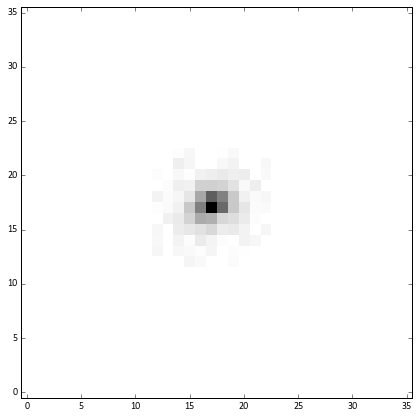

In [220]:
# Show the direct cutout
plt.imshow(beam.thumb*(beam.cutout_seg == beam.id), interpolation='Nearest', 
           origin='lower', cmap='gray_r')

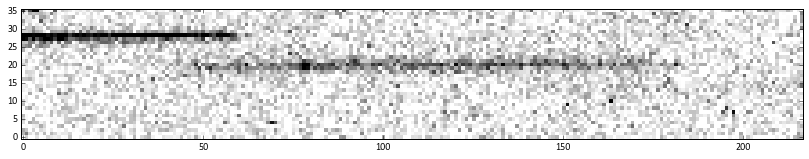

In [221]:
# Show the spectrum cutout
plt.imshow(beam.cutout_sci, interpolation='Nearest', vmin=-0.02, vmax=0.2, 
           cmap='gray_r', origin='lower')

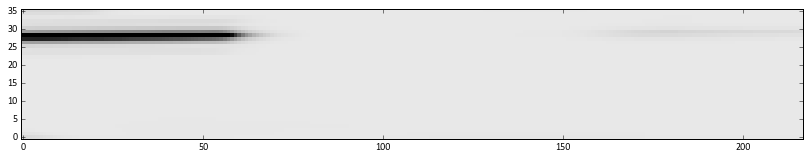

In [222]:
beam.contam = beam.get_cutout(flt.model - model_id)
plt.imshow(beam.contam, interpolation='Nearest', vmin=-0.02, vmax=0.2, 
           cmap='gray_r', origin='lower')

#### `BeamCutout.compute_model`
This is essentially identical to the `GrismFLT.compute_model` function but rather works on the smaller extracted spectrum.

(-0.5, 216.5, -0.5, 35.5)

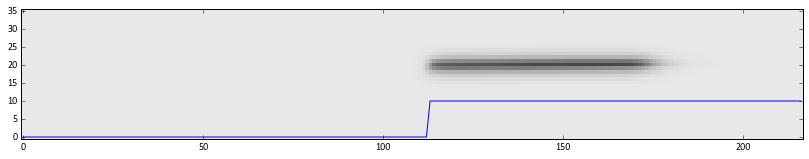

In [223]:
# quick demo of a cartoon "break" spectrum better showing how compute_model works
xspec = np.arange(1.e4, 2.e4,10.)
yspec = (xspec > 1.4e4)*1. # zero at xspec < 1.4e4
dummy_spectrum = beam.compute_model(beam.thumb, id=beam.id, in_place=False,
                                    xspec=xspec, yspec=yspec)

plt.imshow(dummy_spectrum.reshape(beam.shg), interpolation='Nearest', vmin=-0.02, vmax=0.2, 
           cmap='gray_r', origin='lower')

x1,x2,y1,y2 = plt.axis()
plt.plot(np.arange(beam.shg[1]), (beam.wave > 1.4e4)*10.)
plt.axis((x1,x2,y1,y2))
# beam.shg = beam.cutout_sci.shape, the shape of the 2D cutout

In [224]:
# It's (fairly) fast, if still rate-limiting for, e.g., 
# MCMC simulations with thousands of calls
%timeit beam.compute_model(beam.thumb, id=beam.id, in_place=True)

# Can be a bit slower for high resolution template specra since have 
# to do some interpolation along the way
xspec = np.arange(1.e4, 2.e4,10.)
yspec = (xspec > 1.4e4)*1. # zero at xspec < 1.4e4
%timeit beam.compute_model(beam.thumb, id=beam.id, in_place=True, xspec=xspec, yspec=yspec)

xspec = np.arange(1.e4, 2.e4,0.1) # slower
yspec = (xspec > 1.4e4)*1. # zero at xspec < 1.4e4
%timeit beam.compute_model(beam.thumb, id=beam.id, in_place=True, xspec=xspec, yspec=yspec)


1000 loops, best of 3: 511 µs per loop
1000 loops, best of 3: 557 µs per loop
1000 loops, best of 3: 1.49 ms per loop


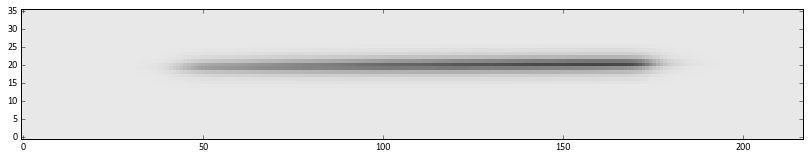

In [225]:
# Compute flat continuum model for the single object
beam.compute_model(beam.thumb, id=beam.id, in_place=True)
# with `in_place=True` the result is stored in the beam.model attribute
cmodel = beam.model*1.
plt.imshow(cmodel, interpolation='Nearest', vmin=-0.02, vmax=0.2, 
           cmap='gray_r', origin='lower')

### 1D "optimal" extractions
The `BeamCutout` class includes a method for computing a 1D optimal extraction of the object spectrum following [Horne (1986)](http://adsabs.harvard.edu/abs/1986PASP...98..609H), where "optimal" refers to the weighting that minimizes the variance in the resulting spectrum by scaling by the object profile along the spatial axis.  Of course collapsing to 1D **always** throws away the spatial information that is needed to interpret the morphology of the spectrum, and this information is often *scientifically* useful, for example in the case of extracting spatially-resolved 2D emission line maps.  Nevertheless, the 1D extractions are often useful for plotting, provided that the *modeling* is done on the full 2D spectrum and the model 1D spectrum is simply extracted in the same way as the data for plotting.

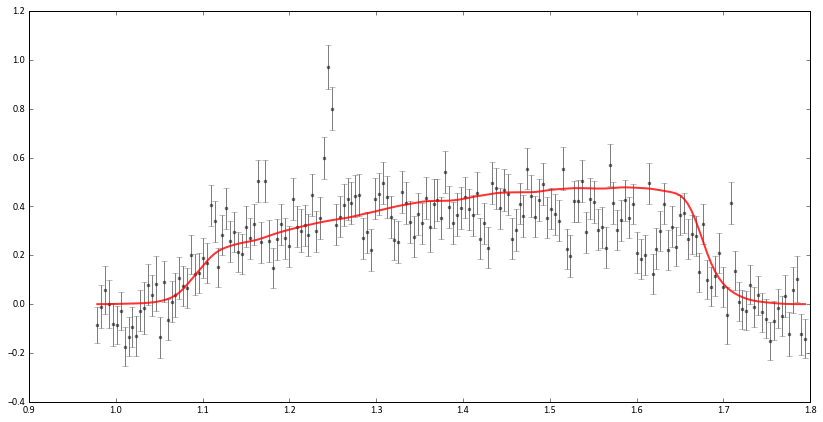

In [226]:
# 1D optimal extraction (Horne 1986)
xspec, yspec, yerr = beam.optimal_extract(beam.cutout_sci, bin=0) #data
xspecm, yspecm, yerrm = beam.optimal_extract(cmodel, bin=0) # continuum model

plt.errorbar(xspec/1.e4, yspec, yerr, linestyle='None', marker='o', markersize=3, color='black', 
             alpha=0.5, label='Data (id=%d)' %(beam.id))

plt.plot(xspecm/1.e4, yspecm, color='red', linewidth=2, alpha=0.8, 
         label=r'Flat $f_\lambda$ (%s)' %(beam.filter))

### Fitting demo: continuum slope and a single emission line
The `BeamCutout.simple_line_fit` method demonstrates a fitting routine that fits for emission line strengths and the continuum shape, where the line centers are fit along a grid spanning the wavelength range of the G141 grism. 

The function first computes the simple flat continuum 2D model spectrum, $C_{i,j}$, as shown earlier.  Then at each line wavelength, $\lambda$, it computes an emission line only model spectrum where the line flux is normalized to unity, $L_{i,j}$.  Scale factors ($\alpha_C$, $\alpha_L$) are then computed with standard least squares techniques [(sklearn.linear_model)](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) to fit the sum of these models to the observed 2D spectrum $S_{i,j}$, which has known (2D) variance, $\sigma^2_{i,j}$ taken directly from the ERR extensions of the FLT images.

We include an additional term for modifying the *slope* of the continuum model, $\alpha_m$, so the final coefficient equation is

$\alpha_C C_{i,j} + \alpha_m \hat\lambda_j C_{i,j} + \alpha_L L_{i,j} = S_{i,j}$, 

where $\hat\lambda_j$ is the wavelength of pixel column $j$, suitably normalized so that $\alpha_m$ is of order unity.

In [227]:
out = beam.simple_line_fit(fwhm=5., grid=[1.12e4, 1.65e4, 1, 20])
line_centers, coeffs, chi2, lmask, lmodel, l0, lflux = out
xspecl, yspecl, yerrl = beam.optimal_extract(lmodel, bin=0)

0, wave=11210.0, chi2=1604.0, line_flux=1.6
2, wave=11250.0, chi2=1603.9, line_flux=1.9
3, wave=11270.0, chi2=1603.7, line_flux=2.2
7, wave=11350.0, chi2=1602.6, line_flux=-2.0
8, wave=11370.0, chi2=1602.6, line_flux=-2.0
9, wave=11390.0, chi2=1600.8, line_flux=-3.6
10, wave=11410.0, chi2=1600.8, line_flux=-3.6
11, wave=11430.0, chi2=1600.7, line_flux=-3.7
30, wave=11810.0, chi2=1599.1, line_flux=-4.1
31, wave=11830.0, chi2=1599.1, line_flux=-4.1
57, wave=12350.0, chi2=1597.5, line_flux=4.5
58, wave=12370.0, chi2=1597.5, line_flux=4.5
59, wave=12390.0, chi2=1567.7, line_flux=10.7
60, wave=12410.0, chi2=1567.7, line_flux=10.7
61, wave=12430.0, chi2=1534.4, line_flux=14.8
62, wave=12450.0, chi2=1534.4, line_flux=14.8


min(chi_nu) = 1.1, nu~1343


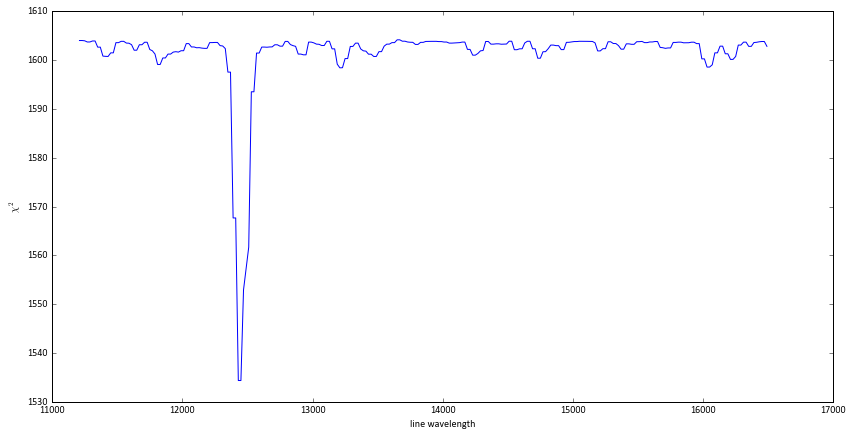

In [228]:
# plot chisq as a function of line wavelength
plt.plot(line_centers, chi2); plt.xlabel('line wavelength'); plt.ylabel(r'$\chi^2$')
print 'min(chi_nu) = %.1f, nu~%d' %(chi2.min()/lmask.sum(), lmask.sum()) # non-masked pixels

In [229]:
# found a line!
print 'z_Halpha ~ %.3f (external z_spec = %.3f)' %(line_centers[np.argmin(chi2)]/6563.-1, 0.895)

z_Halpha ~ 0.897 (external z_spec = 0.895)


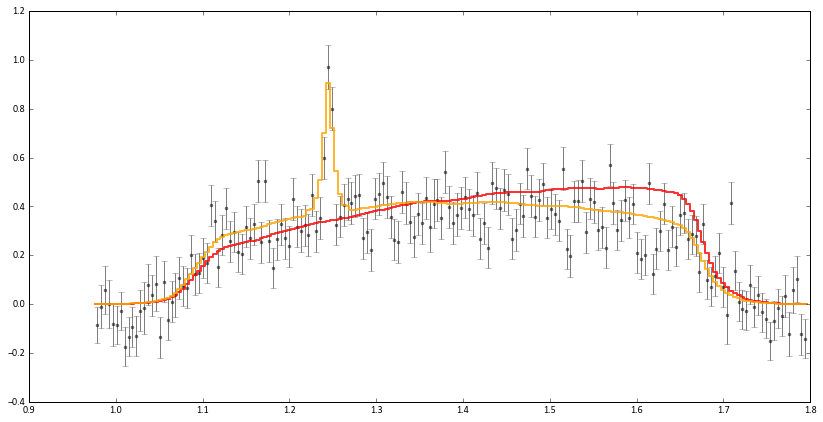

In [234]:
# plot the better model with the observed data
plt.errorbar(xspec/1.e4, yspec, yerr, linestyle='None', marker='o', markersize=3, color='black', 
             alpha=0.5, label='Data (id=%d)' %(beam.id))

plt.plot(xspecm/1.e4, yspecm, color='red', linewidth=2, alpha=0.8, linestyle='steps-mid',
         label=r'Flat $f_\lambda$ (%s)' %(beam.filter))

plt.plot(xspecl/1.e4, yspecl, color='orange', linewidth=2, linestyle='steps-mid', alpha=0.8, 
         label='Cont+line (%.3f, %.2e)' %(l0/1.e4, lflux*1.e-17))

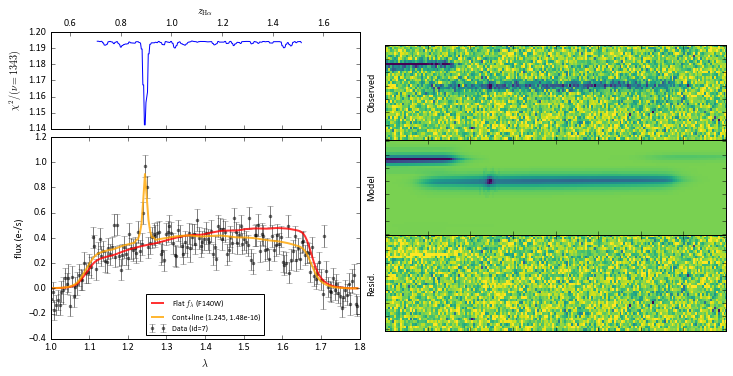

In [232]:
### Full figure
fig = plt.figure(figsize=(10,5))
#fig = plt.Figure(figsize=(8,4))

## 1D plots
gsb = matplotlib.gridspec.GridSpec(3,1)  

ax = fig.add_subplot(gsb[-2:,:])
ax.errorbar(xspec/1.e4, yspec, yerr, linestyle='None', marker='o', markersize=3, color='black', alpha=0.5, label='Data (id=%d)' %(beam.id))
ax.plot(xspecm/1.e4, yspecm, color='red', linewidth=2, alpha=0.8, label=r'Flat $f_\lambda$ (%s)' %(beam.filter))
ax.plot(xspecl/1.e4, yspecl, color='orange', linewidth=2, alpha=0.8, label='Cont+line (%.3f, %.2e)' %(l0/1.e4, lflux*1.e-17))
ax.legend(fontsize=8, loc='lower center', scatterpoints=1)

ax.set_xlabel(r'$\lambda$'); ax.set_ylabel('flux (e-/s)')

ax = fig.add_subplot(gsb[-3,:])
ax.plot(line_centers/1.e4, chi2/lmask.sum())
ax.set_xticklabels([])
ax.set_ylabel(r'$\chi^2/(\nu=%d)$' %(lmask.sum()))

xt = np.arange(1.,1.82,0.1)
for ax in fig.axes:
    ax.set_xlim(1., 1.8)
    ax.set_xticks(xt)

axt = ax.twiny()
axt.set_xlim(np.array(ax.get_xlim())*1.e4/6563.-1)
axt.set_xlabel(r'$z_\mathrm{H\alpha}$')

## 2D spectra
gst = matplotlib.gridspec.GridSpec(3,1)  
if 'viridis_r' in plt.colormaps():
    cmap = 'viridis_r'
else:
    cmap = 'cubehelix_r'

ax = fig.add_subplot(gst[0,:])
ax.imshow(beam.cutout_sci, vmin=-0.05, vmax=0.2, cmap=cmap, interpolation='Nearest', origin='lower', aspect='auto')
ax.set_ylabel('Observed')

ax = fig.add_subplot(gst[1,:])
ax.imshow(lmodel+beam.contam, vmin=-0.05, vmax=0.2, cmap=cmap, interpolation='Nearest', origin='lower', aspect='auto')
ax.set_ylabel('Model')

ax = fig.add_subplot(gst[2,:])
ax.imshow(beam.cutout_sci-lmodel-beam.contam, vmin=-0.05, vmax=0.2, cmap=cmap, interpolation='Nearest', origin='lower', aspect='auto')
ax.set_ylabel('Resid.')

for ax in fig.axes[-3:]:
    ax.set_yticklabels([])
    xi = np.interp(xt, beam.wave/1.e4, np.arange(beam.shg[1]))
    xl = np.interp([1,1.8], beam.wave/1.e4, np.arange(beam.shg[1]))
    ax.set_xlim(xl)
    ax.set_xticks(xi)
    ax.set_xticklabels([])

gsb.tight_layout(fig, pad=0.1,h_pad=0.01, rect=(0,0,0.5,1))
gst.tight_layout(fig, pad=0.1,h_pad=0.01, rect=(0.5,0.1,1,0.9))

fig.savefig('grizli_demo_1.pdf')